## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/umashankar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("complaints.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

In [7]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
df[df['complaint_what_happened'] == ''].index

Int64Index([    0,     3,     4,     5,     6,     7,     8,     9,    12,
               13,
            ...
            78292, 78298, 78299, 78300, 78302, 78304, 78305, 78306, 78307,
            78308],
           dtype='int64', length=57241)

In [9]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened'] == '']  = np.nan

In [10]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [11]:
pd.set_option('display.max_colwidth', -1)
df['complaint_what_happened'].head(1)

<ipython-input-11-d9074bbe7a31>:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
Name: complaint_what_happened, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanup(text):
    text = text.lower()
    pattern = '[^\w\s]' # Removing punctuation
    text = re.sub(pattern, '', text) 
    pattern = '\w*\d\w*'
    text = re.sub(pattern, '', text) 
    text = text.replace("\n", "")
    return text
   

In [13]:
#Write your function to Lemmatize the texts
def lemmatize(text):
    lemma = " ".join([token.lemma_ for token in nlp(text)])
    return lemma



In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(cleanup))
df_clean = pd.DataFrame(df_clean['complaint_what_happened'].apply(lemmatize))


In [15]:
df_clean

,complaint_what_happened
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase
...,...
78303,after be a chase card customer for well over a decade be offer multiple solicitation for acquire new credit card with chase all with bonus airline mile and hotel point be approve for all new card with no annual fee for year after less than month with payment always pay as agree chase close all my card one of my approve new card be never activate but be send to mechase have do harm to my credit have charge I an annual fee even though they cancel my account fail to credit my point for both airline and hotel fail to credit up to for xxxx enrollment and fail to credit airline charge as agree upon
78309,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a claim under their purchase protection benefit on xxxxxxxx I purchase three high school textbook for my xxxx year old daughter because she transfer to a new school all three book be damage when a water bottle in her backpack break the chase representative assure I the textbook would be cover and instruct I to file a claim at xxxx I immediately go to the website and file the claim include upload all of the request paperwork which include a copy of my credit card sta

In [16]:
#Write your function to extract the POS tags 

def pos_tag(text):
    return " ".join([token.text for token in nlp(text) if token.tag_ == "NN"])
  # write your code here



df_clean["complaint_POS_removed"] =  pd.DataFrame(df_clean['complaint_what_happened'].apply(pos_tag))


In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_POS_removed
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund chase bank account money son check money chase bank money time check owner country time date number xxxx claim number chase
...,...,...
78303,after be a chase card customer for well over a decade be offer multiple solicitation for acquire new credit card with chase all with bonus airline mile and hotel point be approve for all new card with no annual fee for year after less than month with payment alw

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




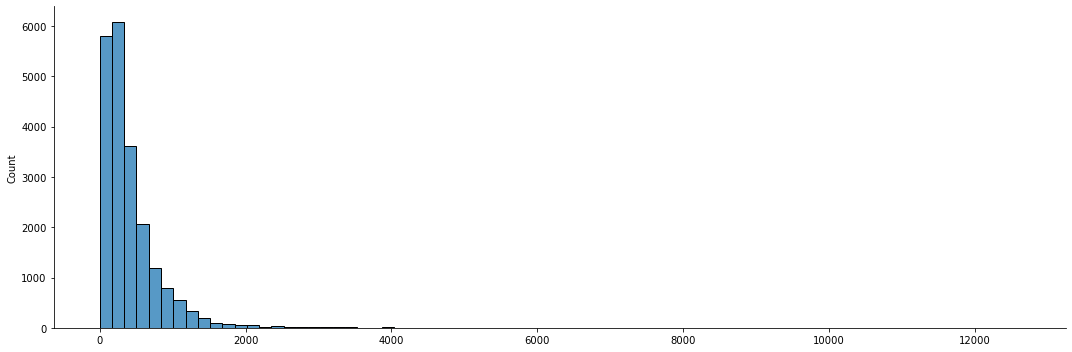

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, bins = 75, height=5, aspect=3)


In [19]:
!pip install wordcloud

#### Find the top 40 words by frequency among all the articles after processing the text.

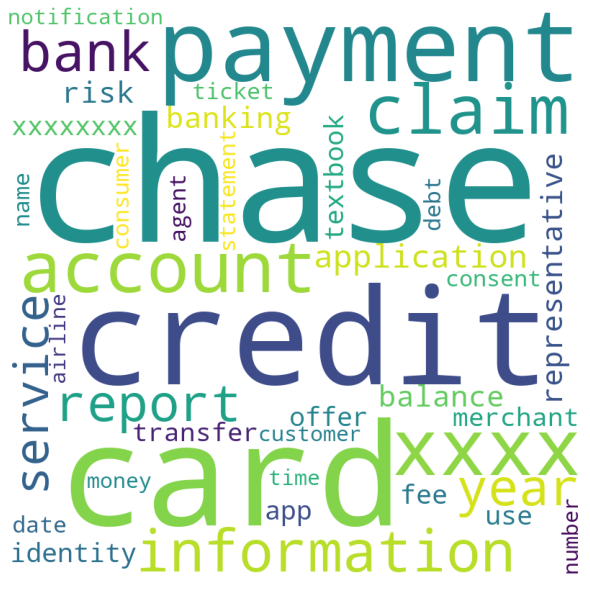

In [20]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800, max_words=40,
                      background_color ='white',stopwords = stopwords, 
                      min_font_size = 8).generate(str(df_clean['complaint_POS_removed']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [21]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

words = ''.join(str(df_clean['Complaint_clean'].tolist()))

from nltk import ngrams
unigram = pd.Series(ngrams(words.split(), 1))
bigram = pd.Series(ngrams(words.split(), 2))
trigram = pd.Series(ngrams(words.split(), 3))

unigram.value_counts()[:30]


(xxxx,)           77261
(account,)        45541
(chase,)          45504
(credit,)         32043
(card,)           29165
(payment,)        20558
(bank,)           16744
(time,)           15585
(charge,)         13465
(day,)            12684
(money,)          11356
(check,)          11006
(xxxxxxxx,)       10724
(loan,)           10447
(information,)    9391 
(letter,)         9191 
(fee,)            8680 
(call,)           8625 
(number,)         8467 
(transaction,)    8348 
(report,)         8289 
(amount,)         8279 
(month,)          8158 
(customer,)       7864 
(year,)           7844 
(balance,)        7535 
(phone,)          7483 
(mortgage,)       7449 
(service,)        7399 
(company,)        7301 
dtype: int64

In [23]:
#Print the top 10 words in the unigram frequency
unigram.value_counts()[:10]

(xxxx,)       77261
(account,)    45541
(chase,)      45504
(credit,)     32043
(card,)       29165
(payment,)    20558
(bank,)       16744
(time,)       15585
(charge,)     13465
(day,)        12684
dtype: int64

In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram.value_counts()[:30]

(xxxx, xxxx)           18774
(credit, card)         11849
(credit, report)       3533 
(customer, service)    3005 
(chase, credit)        2505 
(account, chase)       2437 
(checking, account)    2322 
(account, xxxx)        2307 
(chase, account)       2258 
(xxxx, chase)          2187 
(account, account)     2123 
(bank, account)        2014 
(debit, card)          1913 
(xxxx, account)        1735 
(credit, score)        1601 
(phone, call)          1572 
(card, account)        1527 
(chase, xxxx)          1508 
(number, xxxx)         1489 
(check, account)       1428 
(account, credit)      1379 
(xxxx, credit)         1293 
(xxxx, payment)        1253 
(interest, rate)       1243 
(card, chase)          1228 
(phone, number)        1226 
(business, day)        1220 
(chase, bank)          1213 
(payment, xxxx)        1209 
(money, account)       1192 
dtype: int64

In [25]:
#Print the top 10 words in the bigram frequency
bigram.value_counts()[:10]

(xxxx, xxxx)           18774
(credit, card)         11849
(credit, report)       3533 
(customer, service)    3005 
(chase, credit)        2505 
(account, chase)       2437 
(checking, account)    2322 
(account, xxxx)        2307 
(chase, account)       2258 
(xxxx, chase)          2187 
dtype: int64

In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram.value_counts()[:30]

(xxxx, xxxx, xxxx)                     4406
(chase, credit, card)                  1694
(credit, card, account)                944 
(credit, card, company)                921 
(account, xxxx, xxxx)                  557 
(xxxx, credit, card)                   545 
(credit, card, chase)                  486 
(xxxx, xxxx, chase)                    481 
(credit, card, xxxx)                   466 
(credit, card, credit)                 452 
(account, credit, card)                403 
(xxxx, xxxx, account)                  384 
(inquiry, credit, report)              380 
(card, credit, card)                   371 
(payment, xxxx, xxxx)                  343 
(customer, service, representative)    342 
(credit, reporting, agency)            334 
(charge, credit, card)                 332 
(credit, reporting, act)               331 
(xxxx, xxxx, payment)                  325 
(credit, report, credit)               325 
(name, xxxx, xxxx)                     306 
(xxxx, xxxx, credit)            

In [27]:
#Print the top 10 words in the trigram frequency
trigram.value_counts()[:10]

(xxxx, xxxx, xxxx)         4406
(chase, credit, card)      1694
(credit, card, account)    944 
(credit, card, company)    921 
(account, xxxx, xxxx)      557 
(xxxx, credit, card)       545 
(credit, card, chase)      486 
(xxxx, xxxx, chase)        481 
(credit, card, xxxx)       466 
(credit, card, credit)     452 
dtype: int64

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [28]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [29]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_POS_removed,Complaint_clean
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,ticket offer ticket reward card information offer minute screen decision refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need t

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(use_idf=True, max_df=0.95, min_df = 2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
df = pd.DataFrame(dtm[0].T.todense(), index=tfidf.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

                TF-IDF
debt          0.566303
cardmember    0.329425
stop          0.293023
advance       0.263772
verification  0.259183
morning       0.238137
right         0.223989
bank          0.218730
help          0.196499
consumer      0.182721
mail          0.172971
statement     0.161189
service       0.138339
month         0.130807
information   0.130732
account       0.081580
chase         0.074491
playstation   0.000000
platform      0.000000
platinum      0.000000
plot          0.000000
plight        0.000000
plethora      0.000000
plenty        0.000000
play          0.000000


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40)


In [34]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_ 
len(tfidf.get_feature_names())
 

6864

In [35]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,charge,credit,chase,dispute,fee,purchase,transaction,service,balance,fraud,time,merchant,company,statement
Topic 2,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,letter
Topic 3,check,bank,money,fund,deposit,day,claim,transaction,chase,branch,atm,cash,hold,time,person
Topic 4,account,chase,checking,bank,money,balance,fee,reason,branch,number,transfer,information,business,fund,deposit
Topic 5,credit,report,inquiry,card,score,company,debt,reporting,information,bureaus,application,identity,remove,theft,limit


In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results

array([[0.00320362, 0.01345301, 0.01589002, 0.02299084, 0.01511299],
       [0.01007716, 0.0022644 , 0.        , 0.0131568 , 0.00080878],
       [0.01012625, 0.        , 0.        , 0.00199089, 0.06371146],
       ...,
       [0.01055828, 0.00491411, 0.01188072, 0.01319458, 0.01668627],
       [0.03940234, 0.05797931, 0.        , 0.00670351, 0.00452237],
       [0.00331786, 0.05643686, 0.        , 0.04498518, 0.04030979]])

In [37]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [38]:
df_clean.head()

,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,3
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,4
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,ticket offer ticket reward card information offer minute screen decision refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,4
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they s

In [39]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')


,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
59,I currently have over xxxx chase ultimate reward point which be worth at least around month ago when I try to access my chase ultimate reward account or even activate the bonus on chase freedom I would get show this page that say we be unable to complete your request at this time image attach as well xxxx xxxx at first I think it be just a temporary error which be not uncommon for chase but after week this be still happen so I call customer support they open a ticket got escalate to their tech team but when I would call back to find out what happen they tell I that the case have be close this happen time and each call have take a lot of time to explain the situation and verify a bunch of information go from ultimaterewardscom and chasecom have the same result I m not able to use these point by phone either because the operator for the travel center be not able to access my accountpoint neither I ve try every browser both xxxx and xxxx computer and the xxxx chase phone application you all send I to the page that say we be unable to complete your request at this time on xxxxxxxx I look up some people that work in ultimate reward on xxxx and cold call a vp of customer relation he act like he be helpful at first and we exchange some email he eventually say I can buy a flighthotel use chase sapphire and if I give he the detail he will deduct the appropriate point and credit my credit card for the purchase long story short he be not able to fix anything I can see that I m still collect point but I have not be able to access it I travel a lot and its become a huge inconvenience that I m not able to access these point which I intend to use for travel I need to get this issue resolve asap,reward point month chase bonus freedom page request time image attach xxxx error chase week customer support ticket escalate tech team case time call lot time situation bunch information chasecom result point phone operator travel center accountpoint browser xxxx computer chase phone application page request time reward call vp customer relation email flighthotel use chase sapphire detail point credit card purchase story anything point lot inconvenience point travel issue,reward point month chase bonus freedom page request time image attach error chase week customer support ticket escalate tech team case time call lot time situation bunch information chasecom result point phone operator travel center accountpoint browser computer chase phone application page request time reward call vp customer relation email flighthotel use chase sapphire detail point credit card purchase story anything point lot inconvenience point travel issue,0
52,my roommate be steal my chase debit card and driver license pretend to be I and withdraw money from my account he admit that he figure out my pin because it happen to be the same as my phone password he also admit that he would sneak into my room while I be sleep and put the card back before I wake up he apologize but say he spend the money I try to dispute this with chase but they claim that since my debit card pin number be use that they can not prove it be not I although they advertise that I have fraud protection they refuse to give I my money back atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx atm withdrawl xxxxxxxx,roommate chase debit card driver license money account pin phone password room card money chase debit card pin number use fraud protection money atm,roommate chase debit card driver license money account pin phone password room card money chase debit card pin number use fraud protection money atm,0
40,xxxx xxxx a sofa love seat table and chair and be never deliver debit card charge bank say visa deny claim we have no furniture and no money,xxxx sofa love seat table chair debit card charge visa claim furniture money,sofa love seat table chair debit card charge visa cl

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [40]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [41]:
df_clean.head()

,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,Theft/Dispute reporting
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,Theft/Dispute reporting
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Mortgages/loans
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,ticket offer ticket reward card information offer minute screen decision refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,Mortgages/loans
14,my grand son give I check for I deposit it into my chase account aft

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean.head()

,complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name xxxx stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help,3
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date xxxxxxxx consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,3
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,4
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,ticket offer ticket reward card information offer minute screen decision refer bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application chase fact credit account name report credit report chase information credit report application error,4
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they s

In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [45]:
training_data

,complaint_what_happened,Topic
1,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,3
2,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,3
10,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,4
11,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more information about the xxxx offer and she explain that even if I have be approve the credit offer only gets apply after the first account statement and could not be use to purchase the ticket I then explicitly tell she I be glad I got deny and I be absolutely no long interested in the account I ask that the application be withdraw and the representative oblige this all happen no later than after put in the application on notwithstanding my explicit request not to proceed with the application and contrary to what I be tell by the chase representative chase do in fact go ahead to open a credit account in my name on this be now be report in my credit report and chase have refuse to correct this information on my credit report even though they go ahead to process an application which I do not consent to and out of their error,4
14,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,2
...,...,...
78303,after be a chase card customer for well over a decade be offer multiple solicitation for acquire new credit card with chase all with bonus airline mile and hotel point be approve for all new card with no annual fee for year after less than month with payment always pay as agree chase close all my card one of my approve new card be never activate but be send to mechase have do harm to my credit have charge I an annual fee even though they cancel my account fail to credit my point for both airline and hotel fail to credit up to for xxxx enrollment and fail to credit airline charge as agree upon,0
78309,on wednesday xxxxxxxx I call chas my xxxx xxxx visa credit card provider and ask how to make a claim under their purchase protection benefit on xxxxxxxx I purchase three high school textbook for my xxxx year old daughter because she transfer to a new school all three book be damage when a water bottle in her backpack break the chase representative assure I the textbook would be cover and instruct I to file a claim at xxxx I immediately go to the website and file the claim include upload all of the request paperwork which include a copy

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:

#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## Logistic regression

In [47]:
# Write your code here to build any 3 models and evaluate them using the required metrics


# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [49]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [50]:
logreg.score(X_test, y_test)

0.9020501138952164

In [52]:
# Save Logistic Regression Model
import pickle
pickle.dump(logreg, open("logreg_model.pk1", "wb"))

## Decision tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)


In [70]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [71]:
dt.score(X_test, y_test)

0.7779043280182233

In [72]:
dt_grid = {"max_depth": [3, 5, 8, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [73]:
#hyper parameter tuning
dt_optimized = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_optimized.fit(X_train, y_train);

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [74]:
dt_optimized.score(X_test, y_test)

0.7742976461655278

In [75]:
pickle.dump(dt_optimized, open("dt_model.pk1", "wb"))

## Random Forest

In [53]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [58]:
rf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)

In [59]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.7839787395596052

### Optimizing the tree -  Hyperparameter tuning

In [60]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [62]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf_optimized = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)
rf_optimized.fit(X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [64]:
# Evaluating the tuned model
rf_optimized.score(X_test, y_test)

0.8238420652999241

 Lets try GridsearchCV

In [65]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [3,5,8,13],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [66]:
rf_optimized = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_optimized.fit(X_train, y_train);

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [68]:
# Save Random Forest Model
pickle.dump(rf_optimized, open("rf_model.pk1", "wb"))

# Model Evaluation

In [84]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))
dt_model = pickle.load(open("dt_model.pk1", "rb"))
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

models = []
models.append(('LR', logreg_model))
models.append(('DT', dt_model))
models.append(('RF', rf_model))

In [77]:
# Logistic regression
from sklearn.metrics import confusion_matrix, classification_report

y_pred = logreg_model.predict(X_test)


In [78]:
Topics = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [79]:
print(classification_report(y_test, y_pred, target_names = Topics))

                            precision    recall  f1-score   support

     Bank account services       0.87      0.94      0.90      1127
Credit card / Prepaid card       0.91      0.96      0.94      1200
                    Others       0.90      0.83      0.86       909
   Theft/Dispute reporting       0.91      0.88      0.90      1127
           Mortgages/loans       0.92      0.87      0.90       905

                  accuracy                           0.90      5268
                 macro avg       0.90      0.90      0.90      5268
              weighted avg       0.90      0.90      0.90      5268



In [80]:
# Desicion Tree
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names = Topics))

                            precision    recall  f1-score   support

     Bank account services       0.76      0.80      0.78      1127
Credit card / Prepaid card       0.89      0.81      0.85      1200
                    Others       0.65      0.72      0.68       909
   Theft/Dispute reporting       0.77      0.83      0.80      1127
           Mortgages/loans       0.82      0.68      0.74       905

                  accuracy                           0.77      5268
                 macro avg       0.78      0.77      0.77      5268
              weighted avg       0.78      0.77      0.78      5268



In [81]:
# Random Forest
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names = Topics))

                            precision    recall  f1-score   support

     Bank account services       0.68      0.87      0.76      1127
Credit card / Prepaid card       0.77      0.90      0.83      1200
                    Others       0.93      0.37      0.53       909
   Theft/Dispute reporting       0.66      0.76      0.71      1127
           Mortgages/loans       0.82      0.70      0.75       905

                  accuracy                           0.74      5268
                 macro avg       0.77      0.72      0.72      5268
              weighted avg       0.76      0.74      0.73      5268



# Summary

Results

#### Logistic Regression

The overall accuracy of the Logistic Regression model is 90%.
Precision and Recall are 90% and 90% respectively which makes this is a very good model.

#### Decision Tree

The overall accuracy of the Decision Tree model is 77%
Precision and Recall are 78% and 77% respectively

#### Random Forest

The overall accuracy of the Random Forest model is 74%
Precision and Recall are 76% and 74% respectively 